In [1]:
import torch
import numpy as np
from torchvision.transforms import transforms as T
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.path.append('..')
sys.path.append('../dataset_loader')
sys.path.append('../model')
sys.path.append('../model.utils')
from config import *

In [2]:
from dataset_loader.image_loader import *
from model.resunet import *
from utils import *

In [3]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [4]:
ae = None #flag test = True to get the segmentation mask
#model = nn.DataParallel(c_resunetVAE(arch='c-ResUnetVAE', n_features_start=16, zDIm=64, n_out=1, n_outRec=1,
#                                      pretrained=False, progress=True).to(device))

In [7]:
model = nn.DataParallel(c_resunetVAE(arch='c-ResUnetVAE', n_features_start = 16, n_out = 1, n_outRec=1,
        pretrained = False, progress= True)).to(device)
model.load_state_dict(torch.load('../model_results_torch/hydra_noLongConn_hpc_5.h5'))

Initializing conv2d weights with Kaiming He normal


<All keys matched successfully>

In [6]:
#for m in model.named_parameters():
#    print(m)

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [9]:
test=True

In [10]:
transform = T.Compose([T.Lambda(lambda x: x * 1. / 255),
                       T.ToTensor(),
                       #T.Resize((1040,1400))
                      #T.Lambda(lambda x: x.permute(2, 0, 1))
                       ])


#cells_images = CellsLoader(root + "/DATASET/test/all_images/red/",
#                           root + "/DATASET/test/all_masks/red/", 
#                           val_split=0.3, transform = transform, ae = ae, test = test)
take_these = ['254.tiff', '275.tiff','278.tiff','81.tiff','44.tiff','168.tiff','107.tiff','26.tiff']
#take_these = []
if test:
    
    transform = T.Compose([T.Lambda(lambda x: x * 1. / 255),
                       T.ToTensor(),
                       #T.CenterCrop(512)
                      #T.Lambda(lambda x: x.permute(2, 0, 1))
                       ])

    
    cells_images = CellsLoader(root + "/DATASET/test/all_images/images/",
                               root + "/DATASET/test/all_masks/masks/", 
                               val_split=0.3, grayscale=False,transform = transform, 
                               ae = ae, test = test,
                               
                              priority_list=take_these)
    
    
else:

    cells_images = CellsLoader(root + "/DATASET/train_val/crop_augmented_AE/images/",
                           root + "/DATASET/train_val/crop_augmented_AE/masks/", 
                           val_split=0.3, transform = transform, ae = ae, test = test)

In [60]:
#t = T.CenterCrop(512)

#plt.imshow(t(img).permute(1,2,0))

#mask = y[0]

#plt.imshow(t(mask).permute(1,2,0))

In [11]:
batch_size = 8
test_loader = DataLoader(cells_images, batch_size=batch_size)

In [12]:
for ix, i in enumerate(test_loader):
    x, y = i
    if np.random.random() > 0.8:
        break

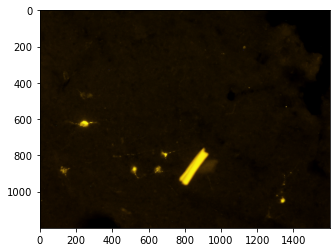

In [13]:
plt.imshow(x[0].permute(1,2,0))

In [14]:
vae = 'vae'

In [21]:
model.eval()
with torch.no_grad():
    if vae:
        gray_RGB, mu, sigma, heatmap, (mu_p, sigma_p) = model(x.to(device))
        recon_loss, au, ne = loss_VAE(mu_p, sigma_p, gray_RGB.to(device))
        #heatmap = (heatmap>0.65)
        target_c0 = gray_RGB
        heatmap = mu_p
        unc = sigma_p
        
        #mu, sigma, heatmap, (mu_p, sigma_p) = model(mu_p.to(device))

        print(heatmap.min(),heatmap.max())
    else:
        heatmap = model(x.to(device))
    if ae:
        ae_image=heatmap

tensor(0.3334, device='cuda:0') tensor(0.9187, device='cuda:0')


In [24]:
target_c0.size()

torch.Size([8, 1, 1200, 1600])

In [86]:
#print((unc==torch.max(unc)).nonzero())

#unc[0][:,530:580,1350:1450].size()

tensor([[   0,    2,  532, 1357]], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


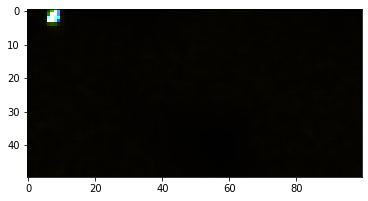

In [29]:
#plt.imshow(unc[0][:,530:580,1350:1450].permute(1,2,0).cpu().detach())

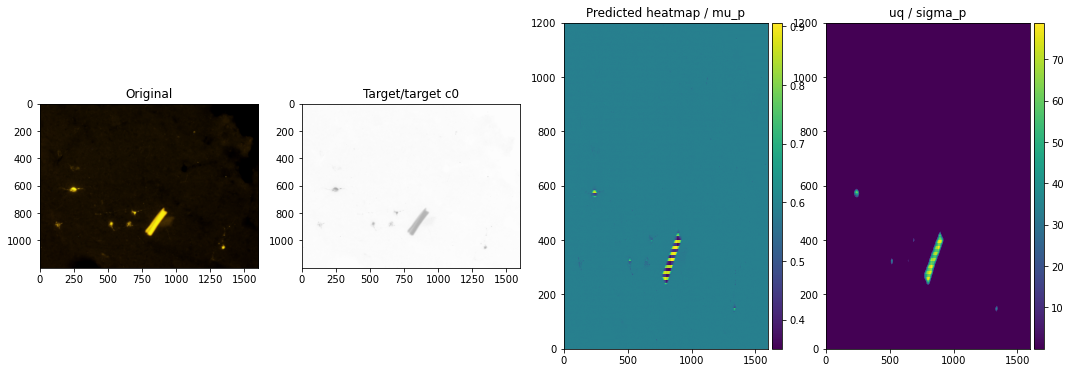

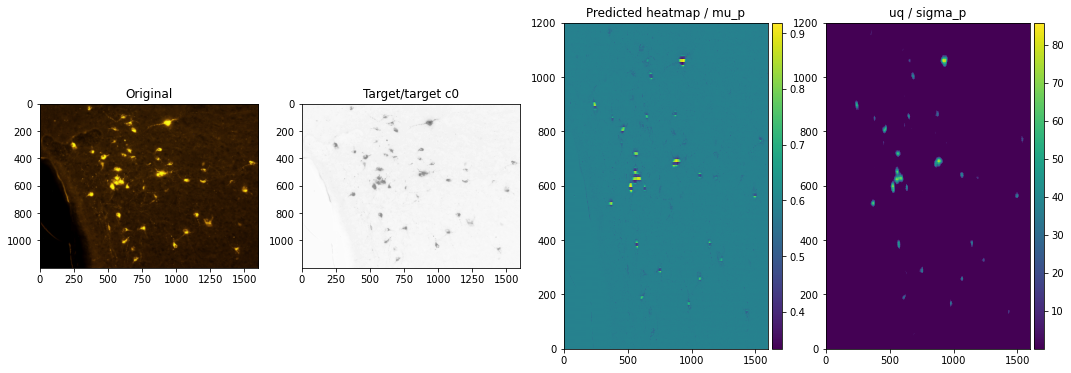

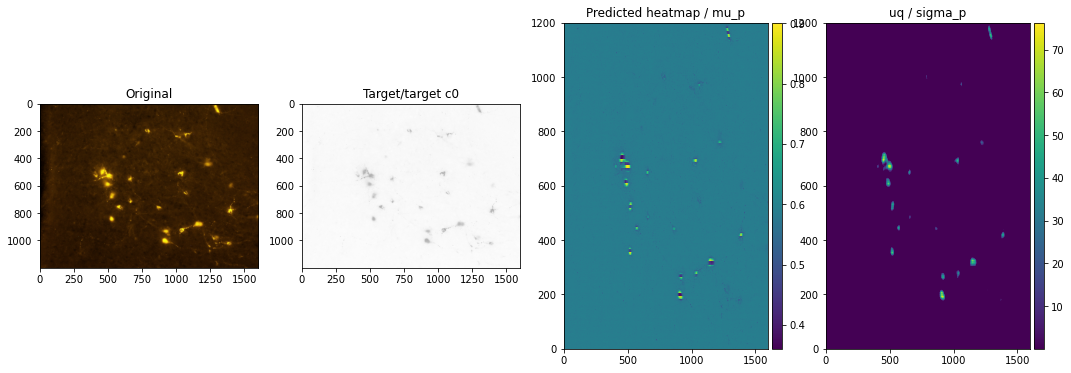

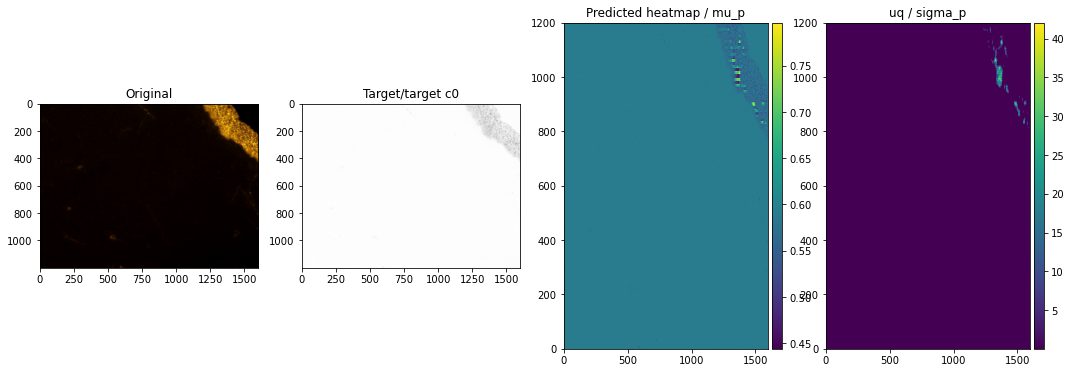

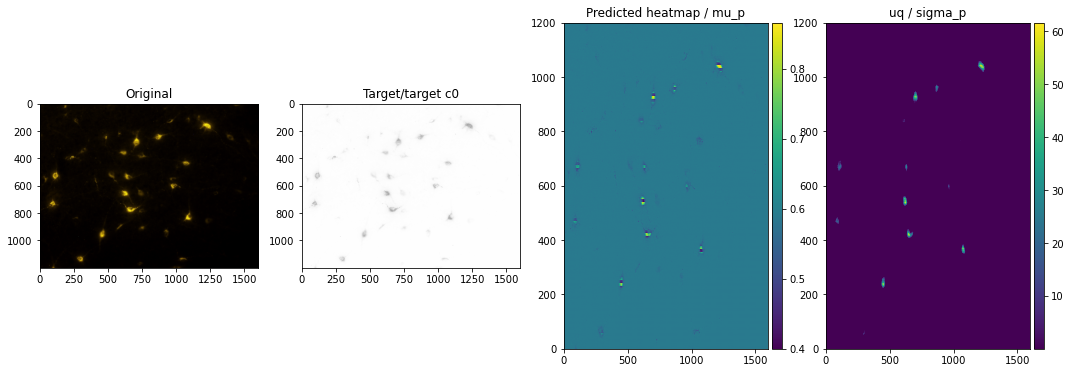

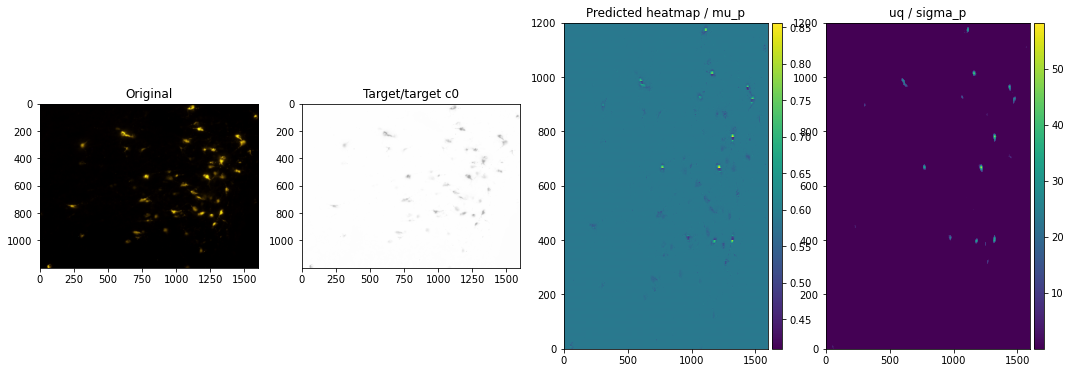

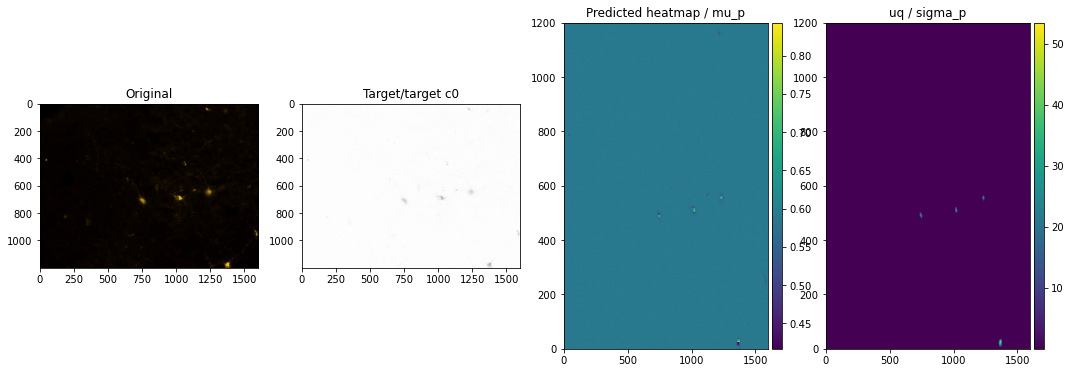

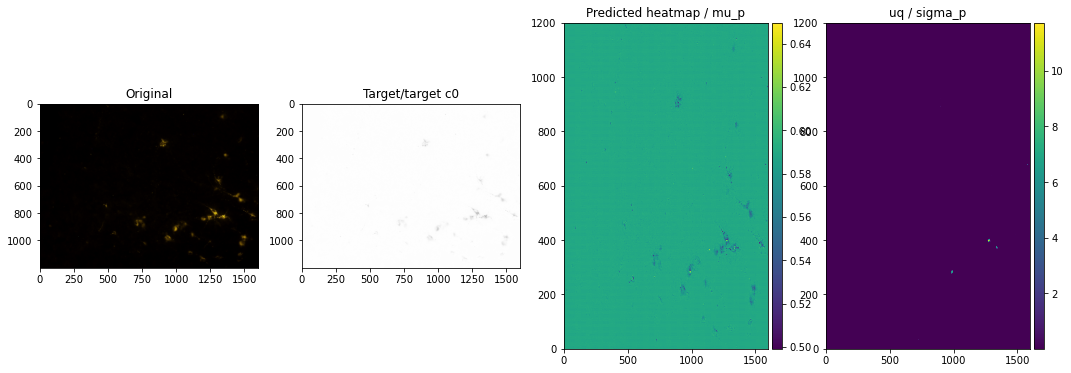

In [22]:
for i in range(heatmap.size()[0]):
    
#     print(test_ids[i+start])
    original = x[i].permute(1,2,0)
    target = y[i].permute(1,2,0)
    target = target_c0[i].permute(1,2,0).cpu().detach()
    heat_map = heatmap[i]
    uq = unc[i].permute(1,2,0).cpu().detach()
    

    fig, axes = plt.subplots(1, 4, figsize=(18, 6))

    
    if ae:
        im = axes[0].imshow(original)
        axes[0].set_title('Original')

        im = axes[1].imshow((target), cmap='gray')
        axes[1].set_title('Target')
        
        im = axes[2].imshow((heat_map.permute(1,2,0).cpu().detach()))
        axes[2].set_title('Predicted heatmap') 
        
    else:        
       
        im = axes[0].imshow(original)
        axes[0].set_title('Original')

        im = axes[1].imshow(np.squeeze(target), cmap='gray')
        axes[1].set_title('Target/target c0')
        
        #im = axes[2].imshow((heat_map.permute(1,2,0).cpu().detach()), cmap='gray')
        #axes[2].set_title('Predicted heatmap binary') 
    
        im = axes[2].pcolormesh(np.flipud(heat_map.cpu().detach().squeeze()))
        divider = make_axes_locatable(axes[2])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        axes[2].set_title('Predicted heatmap / mu_p') 
        
        #im = axes[3].imshow(uq)
        #axes[3].set_title('unc.')
        
        im = axes[3].pcolormesh(np.flipud(uq.cpu().detach().squeeze()))
        divider = make_axes_locatable(axes[3])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        axes[3].set_title('uq / sigma_p') 


In [30]:
transform = T.Compose([T.Lambda(lambda x: x * 1. / 255),
                       T.ToTensor(),
                       T.Resize((1040,1400))
                      #T.Lambda(lambda x: x.permute(2, 0, 1))
                       ])


cells_images = CellsLoader(root + "/DATASET/test/all_images/new/",
                           root + "/DATASET/test/all_masks/new/", 
                           val_split=0.3, grayscale = False,transform = transform, ae = ae, test = test)

In [31]:
batch_size = 1
test_loader = DataLoader(cells_images, batch_size=batch_size)

In [32]:
for ix, i in enumerate(test_loader):
    x, y = i
    if np.random.random() > 0.8:
        break

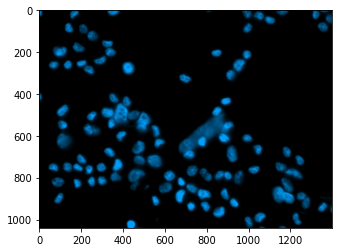

In [33]:
plt.imshow(x[0].permute(1,2,0))

In [34]:
vae = 'vae'

In [36]:
model.eval()
with torch.no_grad():
    if vae:
        gray_RGB, mu, sigma, heatmap, (mu_p, sigma_p) = model(x.to(device))
        recon_loss, au, ne = loss_VAE(mu_p, sigma_p, gray_RGB.to(device))
        #heatmap = (heatmap>0.65)
        target_c0 = x
        #heatmap = mu_p
        unc = au
        
        #mu, sigma, heatmap, (mu_p, sigma_p) = model(mu_p.to(device))

        print(heatmap.min(),heatmap.max())
    else:
        heatmap = model(x.to(device))
    if ae:
        ae_image=heatmap

tensor(8.0159e-08, device='cuda:0') tensor(1., device='cuda:0')


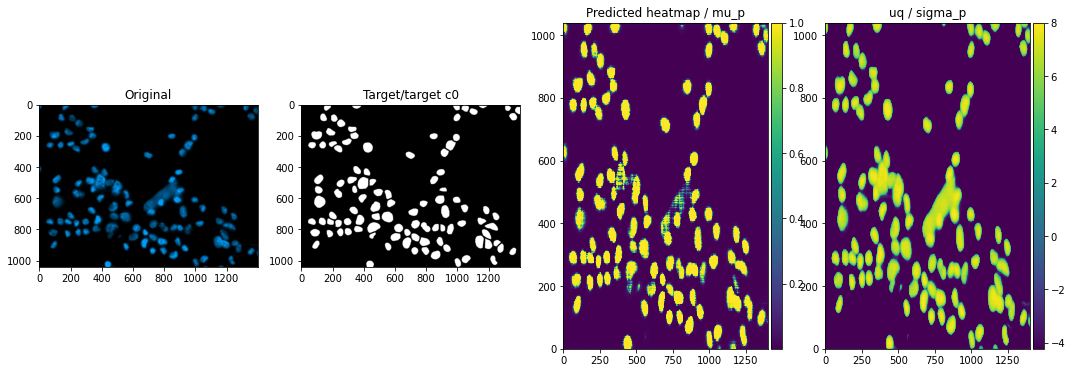

In [37]:
for i in range(heatmap.size()[0]):
    
#     print(test_ids[i+start])
    original = x[i].permute(1,2,0)
    target = y[i].permute(1,2,0)
    #target = target_c0[i].permute(1,2,0).cpu().detach()
    heat_map = heatmap[i]
    uq = unc[i].permute(1,2,0).cpu().detach()
    

    fig, axes = plt.subplots(1, 4, figsize=(18, 6))

    
    if ae:
        im = axes[0].imshow(original)
        axes[0].set_title('Original')

        im = axes[1].imshow((target), cmap='gray')
        axes[1].set_title('Target')
        
        im = axes[2].imshow((heat_map.permute(1,2,0).cpu().detach()))
        axes[2].set_title('Predicted heatmap') 
        
    else:        
       
        im = axes[0].imshow(original)
        axes[0].set_title('Original')

        im = axes[1].imshow(np.squeeze(target), cmap='gray')
        axes[1].set_title('Target/target c0')
        
        #im = axes[2].imshow((heat_map.permute(1,2,0).cpu().detach()), cmap='gray')
        #axes[2].set_title('Predicted heatmap binary') 
    
        im = axes[2].pcolormesh(np.flipud(heat_map.cpu().detach().squeeze()))
        divider = make_axes_locatable(axes[2])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        axes[2].set_title('Predicted heatmap / mu_p') 
        
        #im = axes[3].imshow(uq)
        #axes[3].set_title('unc.')
        
        im = axes[3].pcolormesh(np.flipud(uq.cpu().detach().squeeze()))
        divider = make_axes_locatable(axes[3])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        axes[3].set_title('uq / sigma_p') 


In [46]:
transform = T.Compose([T.Lambda(lambda x: x * 1. / 255),
                       T.ToTensor(),
                       T.Resize((1200,1600)) 
                      #T.Lambda(lambda x: x.permute(2, 0, 1))
                       ])

cells_images = CellsLoader(root + "/DATASET/test/all_images/red/",
                           root + "/DATASET/test/all_masks/red/", 
                           val_split=0.3, grayscale = False, transform = transform, ae = ae, test = test)

In [47]:
batch_size = 1
test_loader = DataLoader(cells_images, batch_size=batch_size)

In [48]:
for ix, i in enumerate(test_loader):
    x, y = i
    if np.random.random() > 0.8:
        break

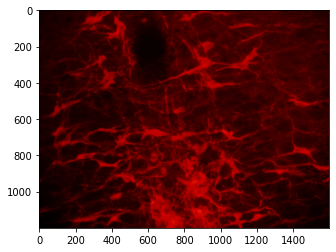

In [49]:
plt.imshow(x[0].permute(1,2,0))

In [50]:
vae = 'vae'

In [51]:
model.eval()
with torch.no_grad():
    if vae:
        gray_RGB, mu, sigma, heatmap, (mu_p, sigma_p) = model(x.to(device))
        recon_loss, au, ne = loss_VAE(mu_p, sigma_p, gray_RGB.to(device))
        #heatmap = (heatmap>0.65)
        target_c0 = x
        #heatmap = mu_p
        unc = au
        
        #mu, sigma, heatmap, (mu_p, sigma_p) = model(mu_p.to(device))

        print(heatmap.min(),heatmap.max())
    else:
        heatmap = model(x.to(device))
    if ae:
        ae_image=heatmap

tensor(0.0010, device='cuda:0') tensor(0.9767, device='cuda:0')


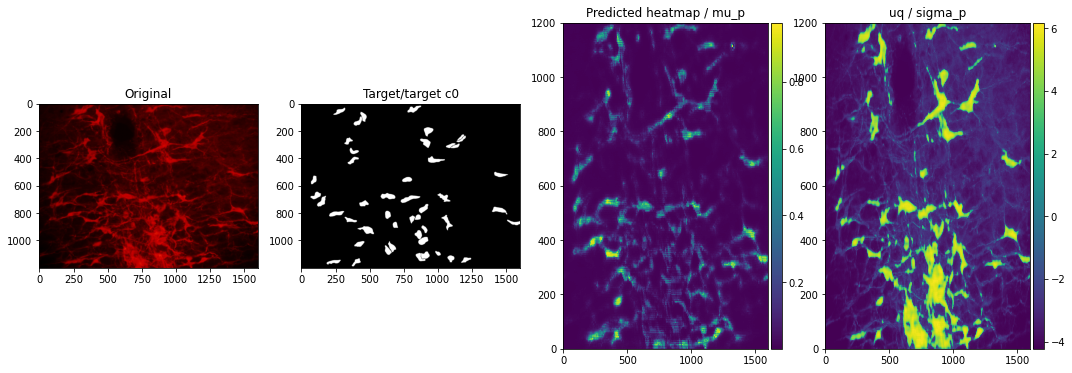

In [52]:
for i in range(heatmap.size()[0]):
    
#     print(test_ids[i+start])
    original = x[i].permute(1,2,0)
    target = y[i].permute(1,2,0)
    #target = target_c0[i].permute(1,2,0).cpu().detach()
    heat_map = heatmap[i]
    uq = unc[i].permute(1,2,0).cpu().detach()
    

    fig, axes = plt.subplots(1, 4, figsize=(18, 6))

    
    if ae:
        im = axes[0].imshow(original)
        axes[0].set_title('Original')

        im = axes[1].imshow((target), cmap='gray')
        axes[1].set_title('Target')
        
        im = axes[2].imshow((heat_map.permute(1,2,0).cpu().detach()))
        axes[2].set_title('Predicted heatmap') 
        
    else:        
       
        im = axes[0].imshow(original)
        axes[0].set_title('Original')

        im = axes[1].imshow(np.squeeze(target), cmap='gray')
        axes[1].set_title('Target/target c0')
        
        #im = axes[2].imshow((heat_map.permute(1,2,0).cpu().detach()), cmap='gray')
        #axes[2].set_title('Predicted heatmap binary') 
    
        im = axes[2].pcolormesh(np.flipud(heat_map.cpu().detach().squeeze()))
        divider = make_axes_locatable(axes[2])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        axes[2].set_title('Predicted heatmap / mu_p') 
        
        #im = axes[3].imshow(uq)
        #axes[3].set_title('unc.')
        
        im = axes[3].pcolormesh(np.flipud(uq.cpu().detach().squeeze()))
        divider = make_axes_locatable(axes[3])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        axes[3].set_title('uq / sigma_p') 



In [81]:
uq.size()

torch.Size([1200, 1600, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


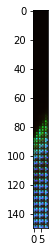

In [83]:
plt.imshow(unc[0][:,800:950,800:810].permute(1,2,0).cpu().detach())

TypeError: Invalid shape (0, 0, 1200, 1600) for image data

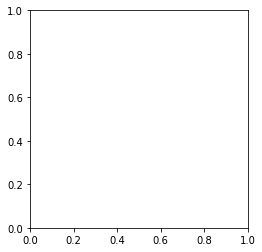

In [37]:
plt.imshow(unc[600:1000,750:].cpu().detach())